<a href="https://colab.research.google.com/github/bolt25/Forecasting_COVID-19/blob/master/Dharmik_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
%cd 'My Drive/Forecasting/Dataset'

/gdrive/My Drive/Forecasting/Dataset


In [127]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import sklearn
import matplotlib.pyplot as plt

In [132]:
df = pd.read_csv('case_time_series.csv')
df.head()

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,30 January,1,1,0,0,0,0
1,31 January,0,1,0,0,0,0
2,01 February,0,1,0,0,0,0
3,02 February,1,2,0,0,0,0
4,03 February,1,3,0,0,0,0


In [129]:
# 0 -> 30 Jan
# 254 -> 10 Oct

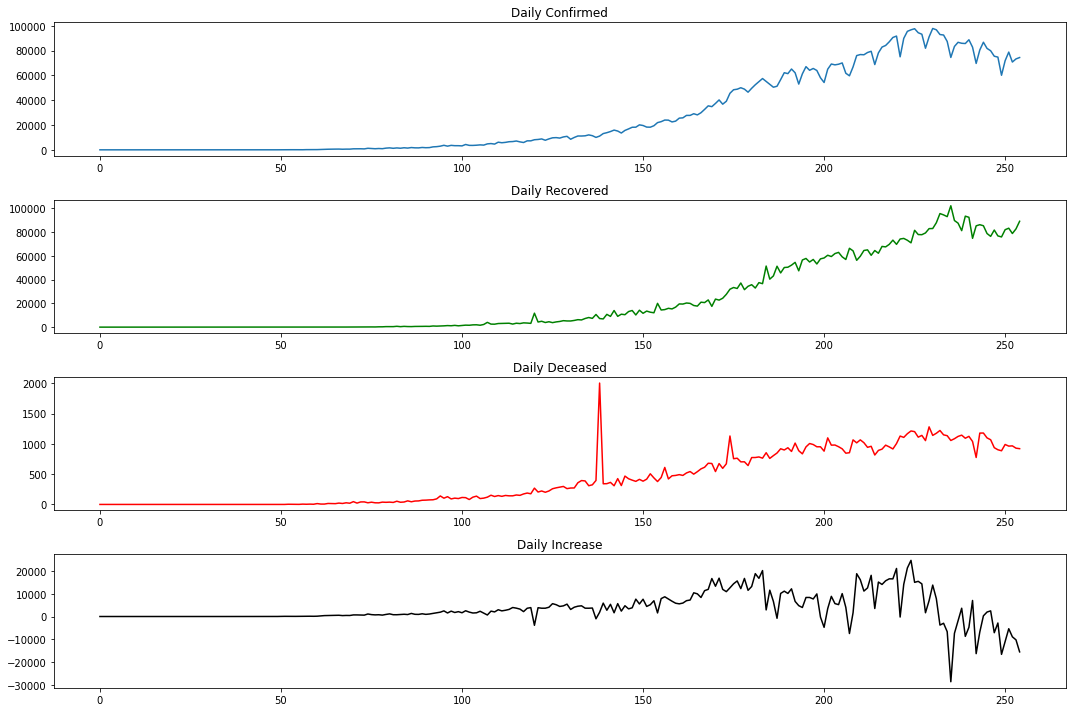

In [130]:
increase = df['Daily Confirmed'] - df['Daily Recovered'] - df['Daily Deceased']
fig,(a1, a2, a3, a4) = plt.subplots(nrows=4, ncols=1, figsize=(15, 10))
a1.plot(df['Daily Confirmed'])
a1.set_title('Daily Confirmed')
a2.plot(df['Daily Recovered'], color = 'green')
a2.set_title('Daily Recovered')
a3.plot(df['Daily Deceased'], color= 'red')
a3.set_title('Daily Deceased')
a4.plot(increase, color= 'black')
a4.set_title('Daily Increase')  # from this grapg we can infer that lately the number of increase in daily positive patients is going down (i.e no of people testing positive is less when compared to number of people getting recovered or deaths reported)
fig.tight_layout()

In [133]:
df = df[['Daily Confirmed', 'Daily Recovered', 'Daily Deceased']]
sc = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
data = sc.fit_transform(df.values)
data = pd.DataFrame(data)
data.shape

(255, 3)

In [186]:
#------------------------------->Data for daily confirmed prediction <------------------
data_train = data.loc[:239].to_numpy()
label_train = data.loc[:239, 0].to_numpy() #df.loc[:239,'Daily Confirmed'].to_numpy()
data_test = data.loc[240:].to_numpy()
label_test = data.loc[240:, 0].to_numpy() #df.loc[240:,'Daily Confirmed'].to_numpy()

In [209]:
# ------------------------------> HYPERPARAMETERS <-------------------------------------
input_dim = 3
hidden_dim = 10
n_layers = 3
batch_size = 1
pred_time = 1 
train_window = 5
output_dim = pred_time

In [210]:
class GRUNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h

In [211]:
#----------------------------> Creating Dataloader <----------------------------------------------------
def create_inout_sequences(input_data, input_label, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_label[i+tw:i+tw+1]
        train_seq = torch.reshape(train_seq, (batch_size, tw, input_dim))
        train_label = torch.reshape(train_label, (batch_size, pred_time, 1))
        inout_seq.append((train_seq ,train_label))
    return inout_seq

# -----------------------------------------> LOADING DATA <----------------------------------------------
train_data_tensor = torch.FloatTensor(data_train)
label_data_tensor = torch.FloatTensor(label_train)
train_inout_seq = create_inout_sequences(train_data_tensor, label_data_tensor, train_window)

test_data_tensor = torch.FloatTensor(data_test)
label_test_data_tensor = torch.FloatTensor(label_test)
test_inout_seq = create_inout_sequences(test_data_tensor, label_test_data_tensor, train_window)

In [212]:
# -----------------> Defining model, loss class & optimizer <-------------------
model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#-------------------------------------------------------------------------------
epochs = 100
h0 = torch.zeros(n_layers, batch_size, hidden_dim)
h0_t = torch.zeros(n_layers, batch_size, hidden_dim)
#-------------------------------> Training loop <------------------------------
for i in range(epochs):
    for seq, labels in train_inout_seq:
      optimizer.zero_grad()
      y_pred, h0 = model(seq, h0)
      single_loss = loss_function(y_pred, labels)
      single_loss.backward()
      h0 = h0.detach()
      optimizer.step()
    if i%24 == 0:
        model.eval()
        for seq_t, labels_t in test_inout_seq:
          y_pred_t, _ = model(seq_t, h0_t)
          test_loss = loss_function(y_pred_t, labels_t)
        print(f'Epoch: {i+1:2}---> Training:- Loss: {single_loss.item():10.8f} ----- Testing:- Loss: {test_loss.item():10.8f}')
        model.train()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:  1---> Training:- Loss: 0.20011452 ----- Testing:- Loss: 0.08855113
Epoch: 25---> Training:- Loss: 0.00659227 ----- Testing:- Loss: 0.00432120
Epoch: 49---> Training:- Loss: 0.00623701 ----- Testing:- Loss: 0.00074237
Epoch: 73---> Training:- Loss: 0.00086835 ----- Testing:- Loss: 0.00089061
Epoch: 97---> Training:- Loss: 0.00009839 ----- Testing:- Loss: 0.00029629


In [218]:
#-------------------> Prediction Snippet<---------------------------------------
h0_pred = torch.zeros(n_layers, batch_size, hidden_dim)
fut_pred = 10
model.eval()
test_inp = []
for i in range(fut_pred):
  to_pred = torch.FloatTensor(data_test[i:i+train_window])
  to_pred = torch.reshape(to_pred, (batch_size, train_window, input_dim))
  seq = to_pred
  with torch.no_grad():
      test_inp.append([model(seq, h0_pred)[0], 0, 0])   #padding to make dimensions equal so as to enable inverse scalar operation
print(test_inp)

[[tensor([[0.6958]]), 0, 0], [tensor([[0.6334]]), 0, 0], [tensor([[0.5638]]), 0, 0], [tensor([[0.6247]]), 0, 0], [tensor([[0.6011]]), 0, 0], [tensor([[0.4526]]), 0, 0], [tensor([[0.5573]]), 0, 0], [tensor([[0.6812]]), 0, 0], [tensor([[0.6067]]), 0, 0], [tensor([[0.5518]]), 0, 0]]


In [ ]:
#---------------------> Inverse scalar transformation <-------------------------
import numpy as np
stats = []
num_features = 3
actual_predictions = sc.inverse_transform(np.array(test_inp).reshape(-1,num_features))
length = len(actual_predictions)
for i in range(length):
  stats.append(int(actual_predictions[i][0]))

In [254]:
a = df['Daily Confirmed'].loc[240:249]
stats_df = []
for i in a:
  stats_df.append(i)

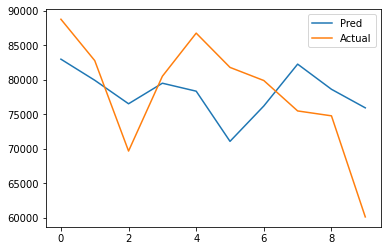

In [255]:
plt.plot(stats)
plt.plot(stats_df)
plt.legend(['Pred', 'Actual'])
plt.show()